<a href="https://colab.research.google.com/github/Keithleezx123/DSL/blob/main/Copy_of_Midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
!pip install git+https://github.com/pe8sutd/eda4u &> /dev/null
!git clone https://github.com/pe8sutd/eda4u &> /dev/null
%load_ext plugin

The plugin extension is already loaded. To reload it, use:
  %reload_ext plugin


DECADE COUNTER + TESTBENCH (BASIC)

In [ ]:
%%verilog

module decade_counter (
    input wire clk,        // Clock input
    input wire rst,        // Reset input
    output reg [4:0] count,// 5-bit count output
    output reg ten         // Ten indicator output
);

    always @(posedge clk or negedge rst) begin
        if (rst == 0) begin
            // Synchronous reset when rst is low
            count <= 5'b00000;
            ten <= 1'b0;
        end
        else begin
            // Normal counting operation
            if (count == 5'b10011) begin
                // Reset to 0 when reaching 19
                count <= 5'b00000;
                ten <= 1'b0;
            end
            else begin
                // Increment count and handle ten signal
                count <= count + 1;
                if (count == 5'b10010) begin
                    ten <= 1'b1;    // Set ten high when count is 18
                end
                else begin
                    ten <= 1'b0;    // Clear ten for all other counts
                end
            end
        end
    end

endmodule
////


module decade_counter_tb();

reg clk;
reg rst;
wire [4:0] count;
wire ten;

decade_counter decade_counter_u0(
    .clk(clk),
    .rst(rst),
    .count(count),
    .ten(ten)
);

initial begin
    clk = 0;
    forever #1 clk = ~clk; // 2 time units period
end

initial begin
    clk = 0;
    rst = 0;
    #3;                  // Hold reset low for 15 time units

    rst = 1;             // Release reset
    #44;                // Run for 200 time units

    rst = 0;             // Assert reset again
    #3;                 // Hold for 20 time units

    rst = 1;             // Release reset
    #70;                // Run for 100 more time units

    $finish;
end
initial begin
    $dumpfile("decade_counter_tb.vcd");
    $dumpvars(0, decade_counter_tb);
end
endmodule

VCD info: dumpfile decade_counter_tb.vcd opened for output.



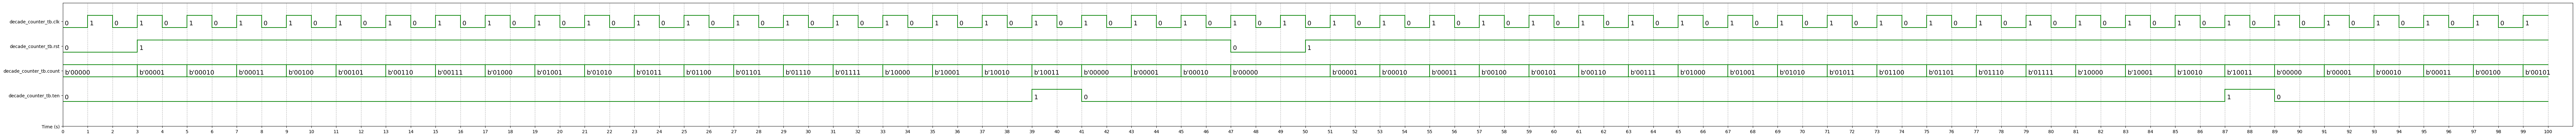

In [ ]:
%%waveform decade_counter_tb.vcd
sign_list = ['decade_counter_tb.clk', 'decade_counter_tb.rst','decade_counter_tb.count','decade_counter_tb.ten']
time_begin = 0
time_end = 100
base = 'bin' # bin, dec, dec2, hex, octal

PARAMETERIZED DECADE COUNTER + BEHAVIORAL TESTBENCH (INTERMEDIATE)

In [90]:
%%verilog
// Parameterised Decade Counter
module decade_counter #(
    parameter MAX_COUNT = 5'b10011,  // Default max count is 19
    parameter TEN_COUNT = 5'b10010,  // Default ten trigger is 18
    parameter WIDTH = 5              // Bit width of counter
) (
    input wire clk,                  // Clock input
    input wire rst,                  // Active-low reset
    output reg [WIDTH-1:0] count,    // Parameterized counter output
    output reg ten                   // Ten indicator output
);

    // Synchronous counter logic
    always @(posedge clk) begin
        if (!rst) begin              // Active-low reset
            count <= {WIDTH{1'b0}};  // Reset to all zeros
        end
        else if (count == MAX_COUNT) begin
            count <= {WIDTH{1'b0}};  // Wrap to 0 when max reached
        end
        else begin
            count <= count + 1;      // Increment
        end
    end

    // Combinatorial ten output logic
    always @(*) begin
        if (!rst) begin
            ten = 1'b0;              // Reset overrides ten
        end
        else begin
            ten = (count == TEN_COUNT);  // Ten high only at TEN_COUNT
        end
    end

endmodule

module decade_counter_tb2;
    // Testbench signals
    reg clk;
    reg rst;
    wire [4:0] count;
    wire ten;

    // Variables declared at module level
    integer i;          // For Test 2 loop
    integer j;          // For Test 3 loop
    integer rand_delay; // For Test 3 random delay
    integer cycle;      // For Test 4 loop
    integer reset_point;// For Test 4 random reset point

    // Instantiate the decade counter (using synchronous reset version)
    decade_counter dut (
        .clk(clk),
        .rst(rst),
        .count(count),
        .ten(ten)
    );

    // Clock generation - 2 time units period
    initial begin
        clk = 0;
        forever #1 clk = ~clk;  // Period = 2 time units
    end

    // Test stimulus and self-checking
    initial begin
        // Initialize VCD for waveform viewing
        $dumpfile("decade_counter_tb2.vcd");
        $dumpvars(0, decade_counter_tb2);

        // Test 1: Reset Functionality
        $display("Test 1: Checking Reset Functionality");
        rst = 0;
        #4;  // Wait 2 clock cycles
        if (count !== 5'b00000 || ten !== 1'b0) begin
            $display("FAILED: Reset - count=%d, ten=%b at time %0t", count, ten, $time);
        end else begin
            $display("PASSED: Reset at time %0t", $time);
        end

        // Test 2: Complete Count Cycle with Verification
        $display("\nTest 2: Verifying Complete Count Cycle");
        rst = 1;
        for (i = 0; i < 20; i = i + 1) begin
            @(posedge clk);  // Wait for each count
            case (count)
                5'b10010: begin  // count = 18
                    if (ten !== 1'b1) begin
                        $display("FAILED: ten should be 1 at count=18, got %b at time %0t", ten, $time);
                    end
                end
                5'b10011: begin  // count = 19
                    if (ten !== 1'b0) begin
                        $display("FAILED: ten should be 0 at count=19, got %b at time %0t", ten, $time);
                    end
                end
                default: begin
                    if (ten !== 1'b0) begin
                        $display("FAILED: ten should be 0 at count=%d, got %b at time %0t", count, ten, $time);
                    end
                end
            endcase
        end
        #2;  // Wait for reset to 0
        if (count !== 5'b00000) begin
            $display("FAILED: Count didn't reset to 0 after 19, got %d at time %0t", count, $time);
        end else begin
            $display("PASSED: Full count cycle completed at time %0t", $time);
        end

        // Test 3: Random Reset Interrupts
        $display("\nTest 3: Random Reset Interrupt Test");
        rst = 1;
        for (j = 0; j < 5; j = j + 1) begin
            rand_delay = $random % 10 + 1;  // Random delay between 1-10
            repeat (rand_delay) @(posedge clk);
            rst = 0;
            #2;  // Wait one clock cycle
            if (count !== 5'b00000 || ten !== 1'b0) begin
                $display("FAILED: Random reset - count=%d, ten=%b at time %0t", count, ten, $time);
            end
            rst = 1;
        end
        $display("PASSED: Random reset test completed at time %0t", $time);

        // Test 4: Multiple Cycles with Reset
        $display("\nTest 4: Multiple Cycles with Mid-Reset");
        rst = 1;
        for (cycle = 0; cycle < 3; cycle = cycle + 1) begin
            reset_point = ($random % 11) + 5;  // Random reset between 5-15
            repeat (reset_point) @(posedge clk);
            rst = 0;
            #2;
            if (count !== 5'b00000 || ten !== 1'b0) begin
                $display("FAILED: Mid-cycle reset - count=%d, ten=%b at time %0t", count, ten, $time);
            end
            rst = 1;
            // Wait for a full cycle (20 edges) and check wrap-around
            repeat (19) @(posedge clk);  // Reach count=19
            if (count !== 5'b10011) begin
                $display("FAILED: Cycle %d didn't reach 19 - count=%d at time %0t", cycle, count, $time);
            end
            @(posedge clk);  // Next edge should wrap to 0
            if (count !== 5'b00000) begin
                $display("FAILED: Cycle %d didn't wrap to 0 - count=%d at time %0t", cycle, count, $time);
            end
        end
        $display("PASSED: Multiple cycles test completed at time %0t", $time);

        #10;
        $finish;
    end

    initial begin
        $monitor("Time=%0t rst=%b count=%d ten=%b", $time, rst, count, ten);
    end
endmodule

VCD info: dumpfile decade_counter_tb2.vcd opened for output.
Test 1: Checking Reset Functionality
Time=0 rst=0 count= x ten=0
Time=1 rst=0 count= 0 ten=0
PASSED: Reset at time 4

Test 2: Verifying Complete Count Cycle
Time=4 rst=1 count= 0 ten=0
Time=5 rst=1 count= 1 ten=0
Time=7 rst=1 count= 2 ten=0
Time=9 rst=1 count= 3 ten=0
Time=11 rst=1 count= 4 ten=0
Time=13 rst=1 count= 5 ten=0
Time=15 rst=1 count= 6 ten=0
Time=17 rst=1 count= 7 ten=0
Time=19 rst=1 count= 8 ten=0
Time=21 rst=1 count= 9 ten=0
Time=23 rst=1 count=10 ten=0
Time=25 rst=1 count=11 ten=0
Time=27 rst=1 count=12 ten=0
Time=29 rst=1 count=13 ten=0
Time=31 rst=1 count=14 ten=0
Time=33 rst=1 count=15 ten=0
Time=35 rst=1 count=16 ten=0
Time=37 rst=1 count=17 ten=0
Time=39 rst=1 count=18 ten=1
Time=41 rst=1 count=19 ten=0
Time=43 rst=1 count= 0 ten=0
PASSED: Full count cycle completed at time 45

Test 3: Random Reset Interrupt Test
Time=45 rst=1 count= 1 ten=0
Time=47 rst=1 count= 2 ten=0
Time=49 rst=1 count= 3 ten=0
Time=51

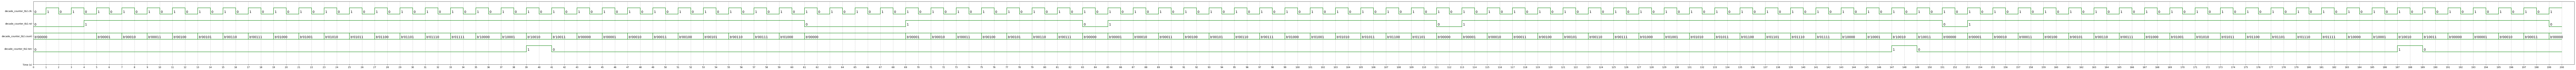

In [ ]:
%%waveform decade_counter_tb2.vcd
sign_list = ['decade_counter_tb2.clk', 'decade_counter_tb2.rst','decade_counter_tb2.count','decade_counter_tb2.ten']
time_begin = 0
time_end = 200
base = 'bin' # bin, dec, dec2, hex, octal

GENERALISED COUNTER (count in both directions) + TESTBENCH (ADVANCED)

In [88]:
%%verilog

module general_counter #(
    parameter WIDTH = 5,
    parameter MAX_COUNT = 5'b10011,
    parameter MIN_COUNT = 5'b00000,
    parameter TARGET_COUNT = 5'b10010
) (
    input wire clk,
    input wire rst,
    input wire up_down,
    output reg [WIDTH-1:0] count,
    output reg target_reached
);
    always @(posedge clk) begin
        if (!rst) begin
            count <= MIN_COUNT;
        end
        else begin
            if (up_down) begin
                if (count == MAX_COUNT) begin
                    count <= MIN_COUNT;
                end
                else begin
                    count <= count + 1;
                end
            end
            else begin
                if (count == MIN_COUNT) begin
                    count <= MAX_COUNT;
                end
                else begin
                    count <= count - 1;
                end
            end
        end
    end

    always @(*) begin
        if (!rst) begin
            target_reached = 1'b0;
        end
        else begin
            target_reached = (count == TARGET_COUNT);
        end
    end
endmodule

module general_counter_tb;
    reg clk;
    reg rst;
    reg up_down;
    wire [4:0] count;
    wire target_reached;

    general_counter dut (
        .clk(clk),
        .rst(rst),
        .up_down(up_down),
        .count(count),
        .target_reached(target_reached)
    );

    initial begin
        clk = 0;
        forever #1 clk = ~clk;  // 2-unit period
    end

    initial begin
        $dumpfile("general_counter_tb.vcd");
        $dumpvars(0, general_counter_tb);

        // Initial state
        rst = 0;
        up_down = 1;
        #4;

        // Test sequence (will be driven by Python)
        rst = 1;
        #40;  // Run for some cycles
        up_down = 0;
        #40;
        rst = 0;
        #4;
        rst = 1;
        #20;

        $finish;
    end

    initial begin
        $monitor("Time=%0t rst=%b up_down=%b count=%d target_reached=%b",
                 $time, rst, up_down, count, target_reached);
    end
endmodule

VCD info: dumpfile general_counter_tb.vcd opened for output.
Time=0 rst=0 up_down=1 count= x target_reached=0
Time=1 rst=0 up_down=1 count= 0 target_reached=0
Time=4 rst=1 up_down=1 count= 0 target_reached=0
Time=5 rst=1 up_down=1 count= 1 target_reached=0
Time=7 rst=1 up_down=1 count= 2 target_reached=0
Time=9 rst=1 up_down=1 count= 3 target_reached=0
Time=11 rst=1 up_down=1 count= 4 target_reached=0
Time=13 rst=1 up_down=1 count= 5 target_reached=0
Time=15 rst=1 up_down=1 count= 6 target_reached=0
Time=17 rst=1 up_down=1 count= 7 target_reached=0
Time=19 rst=1 up_down=1 count= 8 target_reached=0
Time=21 rst=1 up_down=1 count= 9 target_reached=0
Time=23 rst=1 up_down=1 count=10 target_reached=0
Time=25 rst=1 up_down=1 count=11 target_reached=0
Time=27 rst=1 up_down=1 count=12 target_reached=0
Time=29 rst=1 up_down=1 count=13 target_reached=0
Time=31 rst=1 up_down=1 count=14 target_reached=0
Time=33 rst=1 up_down=1 count=15 target_reached=0
Time=35 rst=1 up_down=1 count=16 target_reach

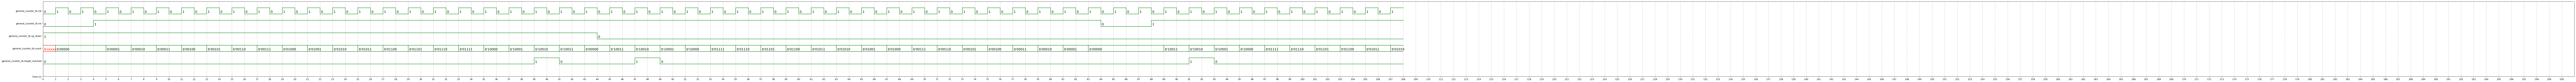

In [ ]:
%%waveform general_counter_tb.vcd
sign_list = ['general_counter_tb.clk', 'general_counter_tb.rst','general_counter_tb.up_down','general_counter_tb.count','general_counter_tb.target_reached']
time_begin = 0
time_end = 200
base = 'bin' # bin, dec, dec2, hex, octal